### Les grandes étapes de notre travail:
- regarder le fichier source et repérer les manquants. Imputer les valeurs manquantes par régression linéaire multiple
- bâtir un premier modèle prédictif sur une régression logistique
- essayer de bâtir un autre modèle prédictif par clustering, évaluer la performance face à la régression logistique
- fournir une conclusion au client et montrer la performance de notre modèle face à des données inconnues

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mtl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels

In [2]:
# on importe le fichier fourni par l'organisation
df_billets = pd.read_csv(r"/home/tanguy/Téléchargements/billets.csv", sep = ';')

In [3]:
df_billets

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [4]:
df_billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [5]:
print('Nous avons: ', df_billets.duplicated().sum(), ' valeurs dupliquées')

Nous avons:  0  valeurs dupliquées


In [6]:
# il nous manque des données pour la variable 'margin_low'
df_billets.isnull().sum().sum()

37

In [7]:
df_billets['id'] = df_billets.index

In [8]:
df_billets.groupby('is_genuine').describe().T

is_genuine                False         True
diagonal     count   500.000000  1000.000000
             mean    171.901160   171.987080
             std       0.306861     0.300441
             min     171.040000   171.040000
             25%     171.690000   171.790000
             50%     171.910000   171.990000
             75%     172.092500   172.200000
             max     173.010000   172.920000
height_left  count   500.000000  1000.000000
             mean    104.190340   103.949130
             std       0.223758     0.300231
             min     103.510000   103.140000
             25%     104.040000   103.740000
             50%     104.180000   103.950000
             75%     104.332500   104.140000
             max     104.880000   104.860000
height_right count   500.000000  1000.000000
             mean    104.143620   103.808650
             std       0.270878     0.291570
             min     103.430000   102.820000
             25%     103.950000   103.610000
             50%     104.160000   103.810000
             75%     104.320000   104.000000
             max     104.950000   104.950000
margin_low   count   492.000000   971.000000
             mean      5.215935     4.116097
             std       0.553531     0.319124
             min       3.820000     2.980000
             25%       4.840000     3.905000
             50%       5.190000     4.110000
             75%       5.592500     4.340000
             max       6.900000     5.040000
margin_up    count   500.000000  1000.000000
             mean      3.350160     3.052130
             std       0.180498     0.186340
             min       2.920000     2.270000
             25%       3.220000     2.930000
             50%       3.350000     3.050000
             75%       3.472500     3.180000
             max       3.910000     3.740000
length       count   500.000000  1000.000000
             mean    111.630640   113.202430
             std       0.615543     0.359552
             min     109.490000   111.760000
             25%     111.200000   112.950000
             50%     111.630000   113.205000
             75%     112.030000   113.460000
             max     113.850000   114.440000
id           count   500.000000  1000.000000
             mean   1249.500000   499.500000
             std     144.481833   288.819436
             min    1000.000000     0.000000
             25%    1124.750000   249.750000
             50%    1249.500000   499.500000
             75%    1374.250000   749.250000
             max    1499.000000   999.000000

### Il serait bien d'avoir un jeu de données complètes. Pour cela nous allons tenter de compléter les valeurs manquantes

#### On va déjà séparer notre dataset en deux parties:
- les individus ayant le margin_low inconnu (à estimer avec notre modèle)
- les individus ayant le margin-low non-null (qui vont servir à construire un modèle)

In [9]:
margin_low_inconnue = df_billets[df_billets['margin_low'].isnull()]
margin_low_connue = df_billets[df_billets['margin_low'].notnull()]

In [10]:
len(margin_low_connue)

1463

In [11]:
# ici sont les 37 individus dont le margin_low est inconnu
margin_low_inconnue

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,id
72,True,171.94,103.89,103.45,NaN,3.25,112.79,72
99,True,171.93,104.07,104.18,NaN,3.14,113.08,99
151,True,172.07,103.80,104.38,NaN,3.02,112.93,151
197,True,171.45,103.66,103.80,NaN,3.62,113.27,197
241,True,171.83,104.14,104.06,NaN,3.02,112.36,241
251,True,171.80,103.26,102.82,NaN,2.95,113.22,251
284,True,171.92,103.83,103.76,NaN,3.23,113.29,284
334,True,171.85,103.70,103.96,NaN,3.00,113.36,334
410,True,172.56,103.72,103.51,NaN,3.12,112.95,410
413,True,172.30,103.66,103.50,NaN,3.16,112.95,413


In [12]:
margin_low_connue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1463 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1463 non-null   bool   
 1   diagonal      1463 non-null   float64
 2   height_left   1463 non-null   float64
 3   height_right  1463 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1463 non-null   float64
 6   length        1463 non-null   float64
 7   id            1463 non-null   int64  
dtypes: bool(1), float64(6), int64(1)
memory usage: 92.9 KB


In [13]:
"""
à présent que l'on a identifié les manquants, nous avons tenter de les combler, à partir du df des margins_low connues
Pour remplir les manquants True, nous n'allons pas utiliser des individus False. Donc nous avons séparer encore une fois, le df
entre les Trues et Falses du df margins_low connues
"""
df_mlc_true = margin_low_connue[margin_low_connue['is_genuine'].eq(True)]
df_mlc_false = margin_low_connue[margin_low_connue['is_genuine'].eq(False)]
# df_mlc_true.drop(columns = 'is_genuine', inplace = True)
# df_mlc_false.drop(columns = 'is_genuine', inplace = True)
df_mlc_true_pairplot = df_mlc_true.drop(columns = 'is_genuine')

df_mli_true = margin_low_inconnue[margin_low_inconnue['is_genuine'].eq(True)]
df_mli_false = margin_low_inconnue[margin_low_inconnue['is_genuine'].eq(False)]
df_mli_true.drop(columns = 'margin_low', inplace = True)
df_mli_false.drop(columns = 'margin_low', inplace = True)

/home/tanguy/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


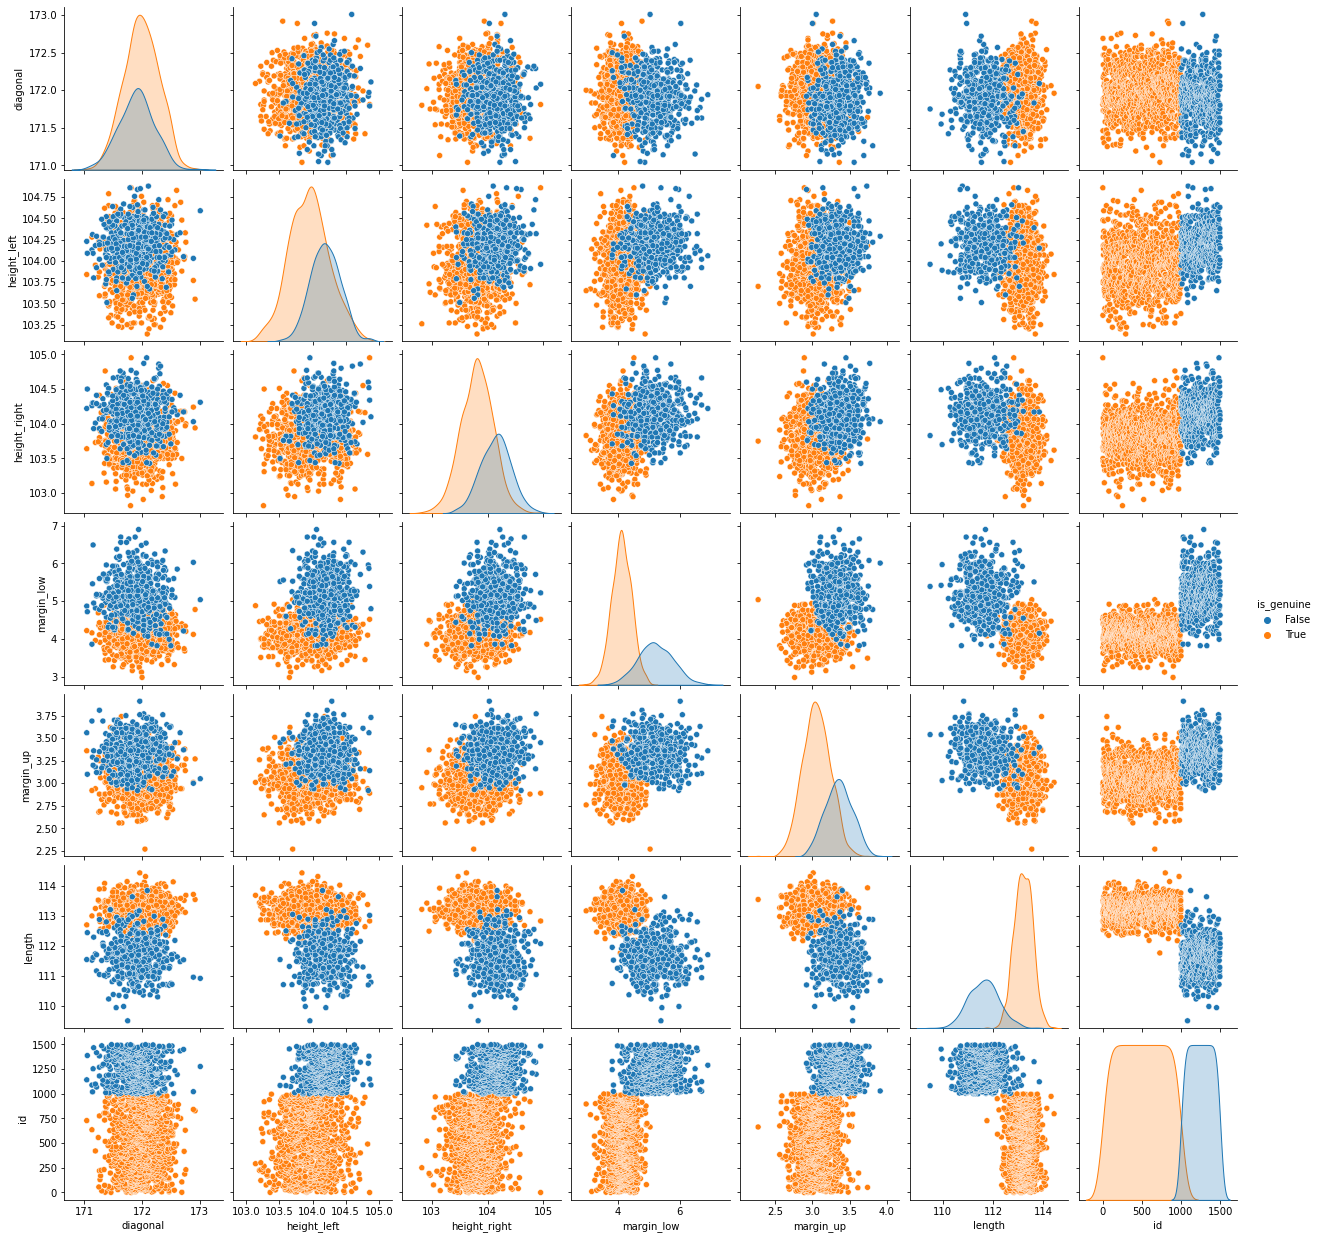

In [14]:
# juste pour regarder si à première vue, il n'y aurait pas de variable qui seraient potentiellement corrélées
sns.pairplot(df_billets, hue='is_genuine')
plt.show()

#### analyse des pairplots: à première vue, rien ne saute aux yeux. Mais gardons en tête que nous souhaitons sélectionner les variables les plus pertinentes pour bâtir notre modèle

##### Petit état des lieux. A présent nous avons quatre df qui vont être utilisés de la manière suivante:
    - les MLC_True vont chercher à prédire les MLI_True
    - les MLC_False vont chercher à prédire les MLI_False

##### On va d'accord imputer les ML_True

In [15]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_mlc_true, test_size=0.2,  shuffle=True)

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 776 entries, 926 to 4
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    776 non-null    bool   
 1   diagonal      776 non-null    float64
 2   height_left   776 non-null    float64
 3   height_right  776 non-null    float64
 4   margin_low    776 non-null    float64
 5   margin_up     776 non-null    float64
 6   length        776 non-null    float64
 7   id            776 non-null    int64  
dtypes: bool(1), float64(6), int64(1)
memory usage: 49.3 KB


In [17]:
from sklearn.linear_model import LinearRegression

X = train[['diagonal', 'height_left','height_right','margin_up','length']]
y = train['margin_low'] 
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.009426761323671706

In [18]:
X_test = test[['diagonal', 'height_left','height_right','margin_up','length']]
y_test = test['margin_low'] 
reg.score(X_test, y_test)

-0.002165708331772098

In [19]:
# on accepte le modèle car on est vraiment dans le même ordre de grandeur

#### Pour la performance du modèle, cela semble fonctionner. Avant de l'accepter définitivement, nous voulons l'évaluer à travers:
- homoscédasticité des résidus, pour un modèle fiable il faut que les résidus soit répartis de manière constante
- normalité des résidus, ils doivent suivre une un modèle linéaire gaussien

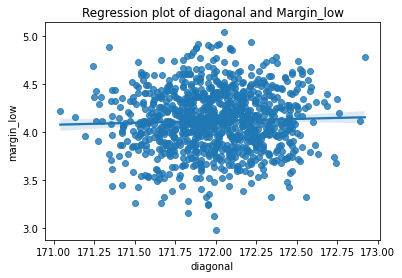

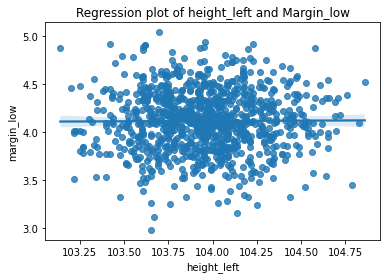

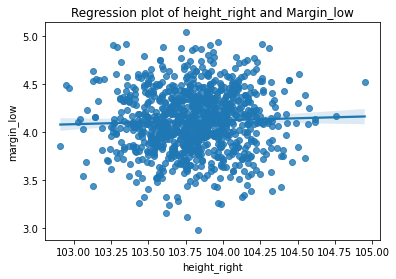

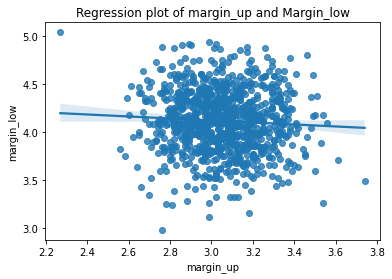

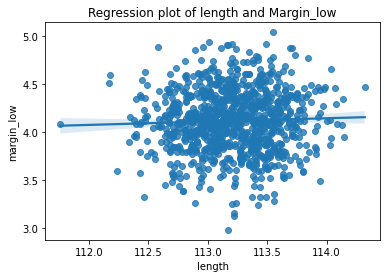

In [20]:
# homoscédasticité: ici sont affichés des pairplots afin de voir la dispersion des individus en fonction de chaque couple "variable qualitative inconnue / variable explicative qualitative"

variables = ['diagonal', 'height_left','height_right','margin_up','length']
for var in variables:
    plt.figure() 
    sns.regplot(x=var, y='margin_low', data=df_mlc_true).set(title=f'Regression plot of {var} and Margin_low');


#### commentaire sur l'homoscédasticité: les populations font des blocs arrondis autour de  notre modèle. Ce n'est pas parfait, mais ce n'est pas non plus de forme conique (le pire). Ici, c'est acceptable

In [21]:
# On va chercher les résidus
prediction = reg.predict(X_test)
residual = (y_test - prediction)
residual

from scipy.stats import t, shapiro
shapiro(residual)

ShapiroResult(statistic=0.9962852001190186, pvalue=0.9202743768692017)

In [22]:
print(residual)

725   -0.257794
980    0.016842
173   -0.376416
50     0.154968
674   -0.287462
         ...   
879   -0.045718
752   -0.199731
728    0.045719
700    0.809859
274    0.321143
Name: margin_low, Length: 195, dtype: float64


<AxesSubplot:>

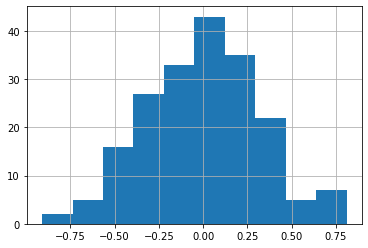

In [23]:
residual.hist()

Le score de Shapiro semble bien confirmer notre hypothèse de normalité des résidus. Car p-value= 0,92> 0,05, et en plus l'histogram montre une distribution quasi-symétrique, avec un nombre d'individus conséquents. Tout nous valide ici la normalité des résidus. 

In [24]:
### Ainsi, nous pouvons avoir raisonnablement confiance en la validité de notre modèle.

In [25]:
df_mli_true.head(2)

,is_genuine,diagonal,height_left,height_right,margin_up,length,id
72,True,171.94,103.89,103.45,3.25,112.79,72
99,True,171.93,104.07,104.18,3.14,113.08,99


In [26]:
X

,diagonal,height_left,height_right,margin_up,length
926,172.15,103.98,103.89,3.08,113.61
575,171.99,104.10,103.57,3.42,113.64
960,171.87,103.88,104.07,2.90,113.36
357,172.33,103.64,104.15,2.93,112.43
808,172.16,104.36,104.02,2.97,113.55
...,...,...,...,...,...
819,172.20,104.01,103.74,3.17,112.94
830,171.49,103.94,103.85,3.32,113.67
934,172.17,104.27,104.32,3.32,113.48
134,172.27,104.12,103.96,2.74,113.12


In [27]:
df_mli_true['margin_low'] = reg.predict(df_mli_true[['diagonal', 'height_left','height_right','margin_up','length']])

/tmp/ipykernel_17277/2748183149.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mli_true['margin_low'] = reg.predict(df_mli_true[['diagonal', 'height_left','height_right','margin_up','length']])


In [28]:
df_mli_true.head(2)

,is_genuine,diagonal,height_left,height_right,margin_up,length,id,margin_low
72,True,171.94,103.89,103.45,3.25,112.79,72,4.066714
99,True,171.93,104.07,104.18,3.14,113.08,99,4.106188


In [29]:
df_ml_true = pd.concat([df_mli_true, df_mlc_true])

In [30]:
df_ml_true['id'].duplicated().sum()

0

In [31]:
df_ml_true.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 72 to 999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1000 non-null   bool   
 1   diagonal      1000 non-null   float64
 2   height_left   1000 non-null   float64
 3   height_right  1000 non-null   float64
 4   margin_up     1000 non-null   float64
 5   length        1000 non-null   float64
 6   id            1000 non-null   int64  
 7   margin_low    1000 non-null   float64
dtypes: bool(1), float64(6), int64(1)
memory usage: 63.5 KB


#### il reste à imputer les False

In [32]:
train, test = train_test_split(df_mlc_false, test_size=0.2,  shuffle=True)

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 1393 to 1135
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    393 non-null    bool   
 1   diagonal      393 non-null    float64
 2   height_left   393 non-null    float64
 3   height_right  393 non-null    float64
 4   margin_low    393 non-null    float64
 5   margin_up     393 non-null    float64
 6   length        393 non-null    float64
 7   id            393 non-null    int64  
dtypes: bool(1), float64(6), int64(1)
memory usage: 24.9 KB


In [34]:
X = train[['diagonal', 'height_left','height_right','margin_up','length']]
y = train['margin_low'] 
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.04285761040792291

In [35]:
X = test[['diagonal', 'height_left','height_right','margin_up','length']]
y = test['margin_low'] 
reg.score(X, y)

-0.07579607106076969

#### commentaire: le score du test False est vraiment proche du score du train. On note cependant un écart légèrement supérieur aux True. Cela s'explique par le nombre d'individus False inférieurs (deux fois moins). Mais on reste vraiment dans le même ordre de grandeur : donc nous acceptons le modèle

In [36]:
df_mli_false.head(2)

,is_genuine,diagonal,height_left,height_right,margin_up,length,id
1076,False,171.57,104.27,104.44,3.21,111.87,1076
1121,False,171.40,104.38,104.19,3.17,112.39,1121


In [37]:
X

,diagonal,height_left,height_right,margin_up,length
1033,171.72,104.06,103.80,3.64,111.77
1312,171.92,104.37,104.05,3.04,110.61
1410,171.96,103.86,103.86,3.55,110.44
1020,171.14,104.31,104.30,3.29,111.57
1074,172.14,104.49,103.76,3.24,110.36
...,...,...,...,...,...
1495,171.75,104.38,104.17,3.09,111.28
1294,172.40,104.27,104.18,3.17,111.79
1360,171.98,104.44,104.26,3.20,110.93
1298,172.00,104.36,104.16,3.25,111.82


In [38]:
df_mli_false['margin_low'] = reg.predict(df_mli_false[['diagonal', 'height_left','height_right','margin_up','length']])

/tmp/ipykernel_17277/3441128366.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mli_false['margin_low'] = reg.predict(df_mli_false[['diagonal', 'height_left','height_right','margin_up','length']])


In [39]:
df_ml_false = pd.concat([df_mli_false, df_mlc_false])

In [40]:
df_ml_false['id'].duplicated().sum()

0

In [41]:
df_ml_false.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1076 to 1499
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    500 non-null    bool   
 1   diagonal      500 non-null    float64
 2   height_left   500 non-null    float64
 3   height_right  500 non-null    float64
 4   margin_up     500 non-null    float64
 5   length        500 non-null    float64
 6   id            500 non-null    int64  
 7   margin_low    500 non-null    float64
dtypes: bool(1), float64(6), int64(1)
memory usage: 31.7 KB


#### à présent on connaît tout, donc nous concaténons une dernière fois et ainsi nous obtenons notre df fourni: sans valeur manquante!

In [42]:
df_billets_complete = pd.concat([df_ml_false, df_ml_true])

In [43]:
df_billets_complete.head(2)

,is_genuine,diagonal,height_left,height_right,margin_up,length,id,margin_low
1076,False,171.57,104.27,104.44,3.21,111.87,1076,5.348595
1121,False,171.40,104.38,104.19,3.17,112.39,1121,5.346018


In [44]:
df_billets_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 1076 to 999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_up     1500 non-null   float64
 5   length        1500 non-null   float64
 6   id            1500 non-null   int64  
 7   margin_low    1500 non-null   float64
dtypes: bool(1), float64(6), int64(1)
memory usage: 95.2 KB


## Deuxième étape: maintenant que l'on a notre dataset d'entraînement de modèle, nous allons appliquer une régression logistique pour tenter de déterminer à l'avenir, si un billet est vrai ou faux en fonction de ses caractèristiques

In [45]:
len(df_billets_complete)

1500

In [46]:
df_billets_complete.head()

,is_genuine,diagonal,height_left,height_right,margin_up,length,id,margin_low
1076,False,171.57,104.27,104.44,3.21,111.87,1076,5.348595
1121,False,171.40,104.38,104.19,3.17,112.39,1121,5.346018
1176,False,171.59,104.05,103.94,3.02,111.29,1176,5.428276
1303,False,172.17,104.49,103.76,2.93,111.21,1303,5.418274
1315,False,172.08,104.15,104.17,3.40,112.29,1315,5.101830


In [47]:
df_billets_complete.loc[:,'is_genuine'] = df_billets_complete['is_genuine'].apply(lambda x: 1 if (x == True) else 0)

In [48]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_billets_complete, test_size=0.2,  shuffle=True)

In [49]:
reg_log1 = smf.glm('is_genuine ~ diagonal+height_left+height_right+margin_low+margin_up+length', data=train, family=sm.families.Binomial()).fit()

print(reg_log1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                            GLM   Df Residuals:                     1193
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20.900
Date:                Sun, 31 Jul 2022   Deviance:                       41.801
Time:                        21:34:44   Pearson chi2:                     266.
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -514.2743    348.293     -1.477   

### Ici, certaines variables ont des p-values supérieures à notre seuil de 0,05, ce qui nous indique qu'elles ne sont pas significatives. On va donc les éliminer une à une. La 'diagonal' est la première à sortir. 

In [50]:
reg_log1 = smf.glm('is_genuine ~ height_left+height_right+margin_low+margin_up+length', data=train, family=sm.families.Binomial()).fit()

print(reg_log1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                            GLM   Df Residuals:                     1194
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21.079
Date:                Sun, 31 Jul 2022   Deviance:                       42.158
Time:                        21:34:44   Pearson chi2:                     265.
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -364.9959    236.551     -1.543   

In [51]:
# au tour de 'height_left' de partir

reg_log1 = smf.glm('is_genuine ~ height_right+margin_low+margin_up+length', data=df_billets_complete, family=sm.families.Binomial()).fit()
reg_log1.save('modele_pret')
print(reg_log1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                            GLM   Df Residuals:                     1495
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -40.183
Date:                Sun, 31 Jul 2022   Deviance:                       80.367
Time:                        21:34:44   Pearson chi2:                 3.43e+03
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -283.6567    139.301     -2.036   

#### à présent nous avons déterminer les 4 variables à prendre en compte pour déterminer si un billet est vrai ou faux
Nous allons vérifier cela sur notre set de test:

In [52]:
test.head(2)

,is_genuine,diagonal,height_left,height_right,margin_up,length,id,margin_low
1179,0,171.47,104.28,103.89,3.21,111.80,1179,5.78
627,1,172.00,104.23,103.74,2.76,112.96,627,4.41


In [53]:
df_test = test.loc[:,['is_genuine','height_right','margin_low','margin_up','length','id']]
df_test.head(1)

,is_genuine,height_right,margin_low,margin_up,length,id
1179,0,103.89,5.78,3.21,111.8,1179


In [54]:
from statsmodels.regression.linear_model import OLSResults
reg_log1 = OLSResults.load("modele_pret")

In [55]:
predict = reg_log1.predict(df_test)

In [56]:
prediction = pd.DataFrame({'id': df_test['id'],'prediction' : predict.values})
prediction['Vrai/Faux_predit'] = prediction['prediction'].apply(lambda x: True if (x >= 0.5) else False)

In [57]:
prediction.head(15)

,id,prediction,Vrai/Faux_predit
1179,1179,6.875793e-06,False
627,627,9.998852e-01,True
1217,1217,1.213802e-05,False
299,299,9.999972e-01,True
553,553,9.998438e-01,True
375,375,9.999964e-01,True
1486,1486,6.689385e-03,False
322,322,9.999370e-01,True
511,511,9.997054e-01,True
945,945,9.996331e-01,True


#### à présent, notre algorithme (régression logistique), est appliquée à la partie test. Il nous faut vérifier cela avec le vrai résultat, celui qui était là à l'origine

In [58]:
df_verif = prediction.merge(df_billets, how='left', on ='id')

In [59]:
df_verif = df_verif.loc[:,['id','prediction','Vrai/Faux_predit','is_genuine']]
df_verif

,id,prediction,Vrai/Faux_predit,is_genuine
0,1179,6.875793e-06,False,False
1,627,9.998852e-01,True,True
2,1217,1.213802e-05,False,False
3,299,9.999972e-01,True,True
4,553,9.998438e-01,True,True
...,...,...,...,...
295,1490,2.139239e-06,False,False
296,1120,1.408219e-08,False,False
297,415,9.988802e-01,True,True
298,1201,4.659143e-05,False,False


In [60]:
df_table = df_verif.loc[:,['Vrai/Faux_predit','is_genuine']]
df_table 

,Vrai/Faux_predit,is_genuine
0,False,False
1,True,True
2,False,False
3,True,True
4,True,True
...,...,...
295,False,False
296,False,False
297,True,True
298,False,False


In [61]:
performance_modele_log = pd.crosstab(df_table['Vrai/Faux_predit'], df_table['is_genuine'])
performance_modele_log

is_genuine,False,True
Vrai/Faux_predit,,
False,96,2
True,2,200


In [62]:
from sklearn.metrics import precision_score
precision_score = precision_score(df_table['is_genuine'], df_table['Vrai/Faux_predit'])
precision_score

0.9900990099009901

In [63]:
from sklearn.metrics import recall_score
recall_score = recall_score(df_table['is_genuine'], df_table['Vrai/Faux_predit'])
recall_score

0.9900990099009901

In [64]:
print (type(precision_score))
print (type (recall_score))

<class 'numpy.float64'>
<class 'numpy.float64'>


In [65]:
F1 = 2*(precision_score*recall_score) / (precision_score + recall_score)
F1

0.9900990099009901

### Voici donc le résultat de notre modèle de régression logistique

##### nous pouvons chercher une alternative comme modèle, afin de comparer les performances
c'est aussi demandé par le client (utiliser un k-means / clustering)

In [66]:
# Nous reprenons notre table remplie
df_billets_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 1076 to 999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   int64  
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_up     1500 non-null   float64
 5   length        1500 non-null   float64
 6   id            1500 non-null   int64  
 7   margin_low    1500 non-null   float64
dtypes: float64(6), int64(2)
memory usage: 105.5 KB


#### nous voudrions étudier les différents clusters. Pour cela il nous faut savoir à travers quelle variable. Ils faut savoir également le nombre de variable nécessaires etc. 
Ainsi nous allons présenter un ébouli des valeurs propres pour savoir le nombre de variable donnant une bonne réprésentation de la population, où l'intertie est forte. Puis nous observerons ces variables sur un cercle de corrélations. 

In [67]:
# nous voulons à présent observer nos variables via un cercle de corrélation. Nous ne gardons pas de variable discrète pour ce faire
df_pca = df_billets_complete.iloc[:,[1,2,3,4,5,7]]
df_pca.head(1)

,diagonal,height_left,height_right,margin_up,length,margin_low
1076,171.57,104.27,104.44,3.21,111.87,5.348595


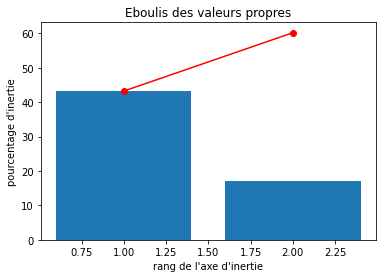

In [68]:
from sklearn import decomposition
from sklearn import preprocessing

# citation de Source: cours Openclassrooms accessible à l'adresse: https://openclassrooms.com/fr/courses/4525281-realisez-une-analyse-exploratoire-de-donnees

# choix du nombre de composantes à calculer
n_comp = 2

X = df_pca.values
names = df_pca.index
features = df_pca.columns

# Centrage et Réduction
std_scale = preprocessing. StandardScaler().fit(X)
x_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components = n_comp)
pca.fit(x_scaled)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
    
display_scree_plot(pca)

In [69]:
# source de ce code: cours Openclassrooms accessible à l'adresse: https://openclassrooms.com/fr/courses/4525281-realisez-une-analyse-exploratoire-de-donnees

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(15,15))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(12,12))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 2.2
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

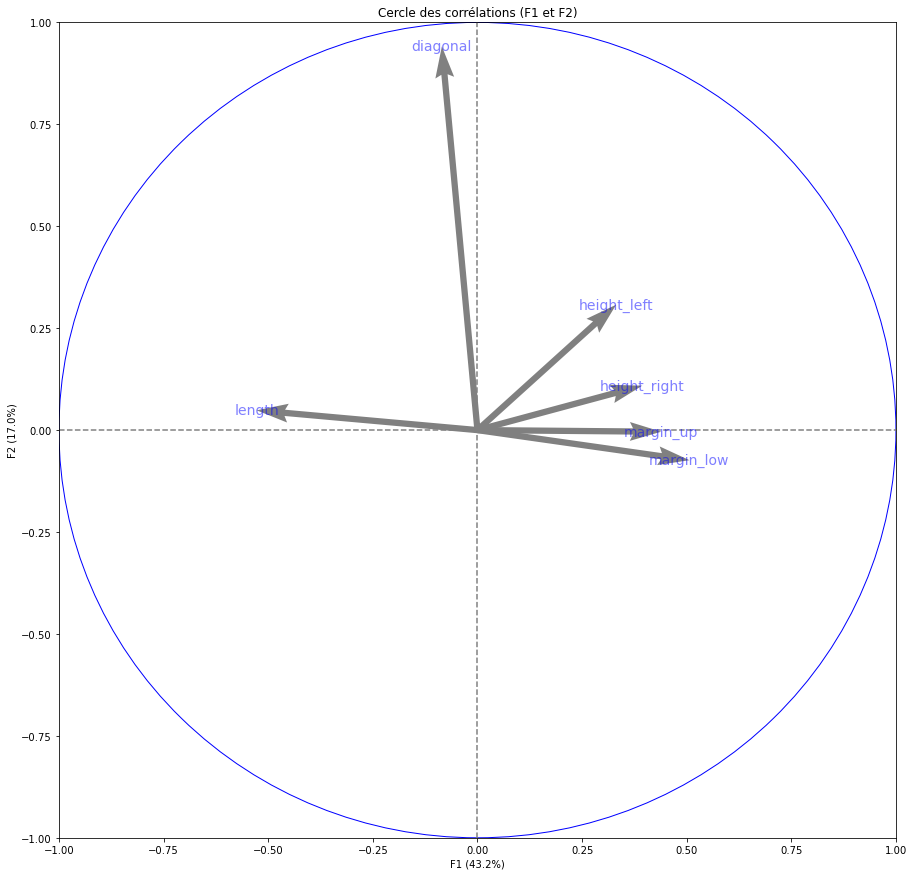

In [70]:
# Cercle des corrélations
pcs= pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

#### commentaire: les marges semblent corrélées entre elles, tout comme les hauteurs. c'est pertinent

In [71]:
## Clustering par k-mean
    
from sklearn.cluster import KMeans
from sklearn import decomposition

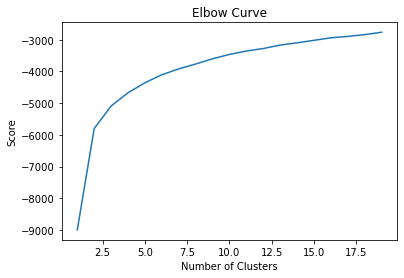

In [72]:
# source de ce code: cours Openclassrooms accessible à l'adresse: https://openclassrooms.com/fr/courses/4525281-realisez-une-analyse-exploratoire-de-donneesx_scaled

# Run a number of tests, for 1, 2, ... num_clusters
num_clusters = 20
kmeans_tests = [KMeans(n_clusters=i, init='random', n_init=10) for i in range(1, num_clusters)]
score = [kmeans_tests[i].fit(x_scaled).score(x_scaled) for i in range(len(kmeans_tests))]

# Plot the curve
plt.plot(range(1, num_clusters),score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [73]:
# nous voulons à présent observer les clusters. Nous ne gardons pas la variable 'id', inutile, ni 'is_genuine' car c'est bien ce que nous voulons prédire ici
df_cluster = df_billets_complete.iloc[:,[1,2,3,4,5,7]]
#df_cluster.reset_index(inplace = True, drop = True)
df_cluster.head(2)

,diagonal,height_left,height_right,margin_up,length,margin_low
1076,171.57,104.27,104.44,3.21,111.87,5.348595
1121,171.40,104.38,104.19,3.17,112.39,5.346018


In [74]:
# Nombre de clusters souhaités
n_clust = 2

# préparation des données pour le clustering
X = df_cluster.values

# Réduire 
x_scaled = preprocessing.StandardScaler().fit_transform(X)

# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(x_scaled)

# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=3).fit(x_scaled)
X_projected = pca.transform(x_scaled)

<AxesSubplot:>

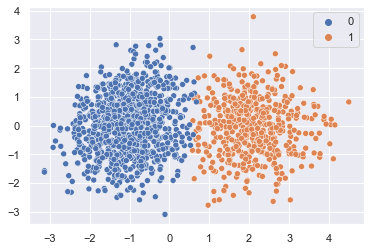

In [75]:
import seaborn as sns
sns.set()
sns.scatterplot(x=X_projected[:, 0], y= X_projected[:, 1], hue= clusters)

In [76]:
clusters

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

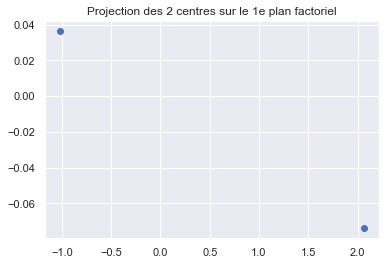

In [77]:
# Affichage des positions des centres de classes
plt.figure()
centroids = km.cluster_centers_
centroids_projected = pca.transform(centroids)
plt.scatter(centroids_projected[:,0],centroids_projected[:,1])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids)))
plt.show()

In [78]:
df_que_clusters = pd.DataFrame(clusters)
df_que_clusters

,0
0,1
1,1
2,1
3,1
4,1
...,...
1495,0
1496,0
1497,0
1498,0


In [79]:
df_comparaison = pd.concat([df_billets_complete, df_que_clusters], axis = 1)
df_comparaison.rename(columns = {0:"cluster_attribue"}, inplace = True)
df_comparaison.head()

,is_genuine,diagonal,height_left,height_right,margin_up,length,id,margin_low,cluster_attribue
0,1,171.81,104.86,104.95,2.89,112.83,0,4.52,1
1,1,171.46,103.36,103.66,2.99,113.09,1,3.77,1
2,1,172.69,104.48,103.50,2.94,113.16,2,4.40,1
3,1,171.36,103.91,103.94,3.01,113.51,3,3.62,1
4,1,171.73,104.28,103.46,3.48,112.54,4,4.04,1


In [80]:
# nommons clairement le cluster attribué
df_comparaison.loc[:,'cluster_attribue'] = df_comparaison['cluster_attribue'].apply(lambda x: False if (x == 1) else True)
df_comparaison.loc[:,'is_genuine'] = df_comparaison['is_genuine'].apply(lambda x: True if (x == 1) else False)

In [81]:
df_comparaison.head()

,is_genuine,diagonal,height_left,height_right,margin_up,length,id,margin_low,cluster_attribue
0,True,171.81,104.86,104.95,2.89,112.83,0,4.52,False
1,True,171.46,103.36,103.66,2.99,113.09,1,3.77,False
2,True,172.69,104.48,103.50,2.94,113.16,2,4.40,False
3,True,171.36,103.91,103.94,3.01,113.51,3,3.62,False
4,True,171.73,104.28,103.46,3.48,112.54,4,4.04,False


In [82]:
df_table = df_comparaison.loc[:,['is_genuine','cluster_attribue']]
df_table 

,is_genuine,cluster_attribue
0,True,False
1,True,False
2,True,False
3,True,False
4,True,False
...,...,...
1495,False,True
1496,False,True
1497,False,True
1498,False,True


In [83]:
performance_modele_clus = pd.crosstab(df_table['is_genuine'], df_table['cluster_attribue'])
performance_modele_clus

cluster_attribue,False,True
is_genuine,,
False,6,494
True,490,510


#### commentaire: ici nous pouvons voir la performance du clustering, qui a du mal à déterminer les faux billets. Dans tous les cas, le modèle de prédiction par clustering sera moins performant que la régression logistique. Entre les deux, nous garderons pour les besoins de notre client, le modèle de régression logistique. Nous sommes désormais prêts à montrer à notre client l'efficacité de notre modèle de prédiction par régression logistique

## Utilisons notre modèle pour tenter de prédire l'authenticité ou non de billets dont nous n'avons pas d'information. 

In [84]:
# ici est notre nouveau data set
nouveau_dataset = pd.read_csv(r"/home/tanguy/Téléchargements/billets_production2.csv", sep = ',')

In [85]:
nouveau_dataset.head(4)

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4


In [86]:
nouveau_dataset = nouveau_dataset[['height_right', 'margin_low', 'margin_up', 'length']]
predict = reg_log1.predict(nouveau_dataset)

prediction=pd.DataFrame({'id': nouveau_dataset.index,
                         'prediction' : predict.values})
prediction['is_genuine_pred'] = prediction['prediction'].apply(lambda x: True if (x >= 0.5) else False)
print(prediction)

   id  prediction  is_genuine_pred
0   0    0.000030            False
1   1    0.000002            False
2   2    0.000010            False
3   3    0.996131             True
4   4    0.999993             True
